# ViSudoku

This program can solve a sudoku puzzle if you show it.

In [1]:
import cv2 as cv
import numpy as np

from functools import reduce
import subprocess

import pickle
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

## Getting the image

In this section, we take the sudoku image which we want to solve

We allow two methods for this: 

- Through an already captured image [change the path below]
- Through the webcam, live

In [2]:
# if path is valid, we take stored image else live input from webcam

def get_sudoku_image(path):
    img = cv.imread(path)
    
    if img is not None:
        # Image will be loaded from disk
        return img
    else:
        # Image will be taken from webcam
        # ensure that proper drivers exist and the webcam works
        # press `c` to capture the image

        cap = cv.VideoCapture(0)
        cv.namedWindow('live')

        while True:
            ret, frame = cap.read()

            cv.imshow('live', frame)

            if cv.waitKey(1) & 0xFF == ord('c'):
                img = frame
                break

        cap.release()
        cv.destroyWindow('live')

        return img

## Basic pre-processing

It is recommended to convert our image to grayscale for processing. For most applications, color serves no major purpose. It is also recommended to blur the image so as to reduce noise in the image.

In this section, we

- Convert image to grayscale
- Blur it
- Binarize it [use only black/white]

In [3]:
# TODO: play around with kernel size for blurring and threshold

def pre_process(img):
    # convert to gray if not already gray
    if len(img.shape) == 3:
        proc = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    else:
        proc = img

    proc = cv.GaussianBlur(proc, (5, 5), 0)
    proc = cv.adaptiveThreshold(proc, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
    
    return proc

## Extracting the puzzle

Now that we have the binarized image, we can extract the puzzle from the image.

In this section, we

- find all contours
- find the largest contour [largest by area]
- get it's corners

#### What? Why? How?!:
- It is assumed that if someone shows an image of a sudoku puzzle, it will be the largest object in the image, which is a reasonable assumption to make. So, we get all the boundaries and the one with the largest area will be our puzzle.
- To extract the corners, we use the following logic [consider (0, 0) to be the top left corner]:
    - Top Left corner will have minimum `x + y`
    - Top Right corner will have maximum `x - y`
    - Bottom Right corner will have maximum `x + y`
    - Bottom Left corner will have minimum `x - y`

In [4]:
def get_largest_contour(contours):
    return max(contours, key=lambda cnt: cv.contourArea(cnt))

def get_contour_corners(contour):
    sum_xy = [pt[0][0] + pt[0][1] for pt in contour]
    diff_xy = [pt[0][0] - pt[0][1] for pt in contour]
    
    indices = [
        np.argmin(sum_xy),
        np.argmax(diff_xy),
        np.argmax(sum_xy),
        np.argmin(diff_xy)
    ]
    
    return [contour[i][0] for i in indices]

def get_corners(img):
    # this weird syntax is used to make this compatible with both opencv v4 and v3
    contours = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2]

    puzzle_bound = get_largest_contour(contours)

    return get_contour_corners(puzzle_bound)

def extract_rect(img, corners, final_size=(450, 450)):
    # returns the euclidian distance between 2 points
    dist = lambda p1, p2: np.linalg.norm(np.array(p1) - np.array(p2))

    tl, tr, br, bl = corners

    # choose the side of final image as maximum of all sides
    side = max([dist(tl, tr), dist(tr, bl), dist(br, bl), dist(bl, tl)])

    # initial points / coords
    src = np.array([tl, tr, br, bl], 'float32')
    # final points / coords
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], 'float32')

    # transform image to get just the puzzle
    m = cv.getPerspectiveTransform(src, dst)
    puzzle = cv.warpPerspective(img, m, (int(side), int(side)))
    
    # resize to final_size
    puzzle = cv.resize(puzzle, final_size)

    return puzzle


def mark_boundary(img, corners):
    """
    This is purely for visualisation purposes.
    
    This draws a box on the image with the specified corners
    """

    tl, tr, br, bl = [tuple(x) for x in corners]
    
    # b, g, r
    color = (255, 0, 0)
    
    cv.line(img, tl, tr, color, 3)
    cv.line(img, tr, br, color, 3)
    cv.line(img, br, bl, color, 3)
    cv.line(img, bl, tl, color, 3)
    
    return img

## Extract digits

Now that we have the puzzle boundary, we need to extract each digit out of it. To do this, I have done the following:
- dilate then erode then image: This ensures that all grid lines are connected
- add a border to the image: This ensures that any part of the grid which might have been lost in trying to 'flatten' the image is restored
- Get the grid lines using `cv.HoughLines`, and then, draw them again to make the grid lines prominent
- erode then dilate: this removes any unnecessary small blobs [noise] from the image so they don't interfere in contour detection
- Get 82 largest contours(by area). The largest one will be the whole puzzle. the other 81 will be the boxes inside which digits are present
 - To get them in the correct order, I check the center of the image, then approxiamate it. This approxiamation is required since the coordinated weren't perfect, so, some images came out of order.

In [5]:
def is_mostly_empty(img, thresh=0.1):
    total = img.shape[0] * img.shape[1]
    white = np.count_nonzero(img)
    
    return white / total < thresh


def approx_center(center):
    min_dist = float("inf")
    cx, cy = center
    
    for x in range(9):
        dist = abs(center[0] - (25 + 50*x))
        if dist < min_dist:
            min_dist = dist
            cx = (25 + 50*x)
            
    min_dist = float("inf")        
    
    for y in range(9):
        dist = abs(center[1] - (25 + 50*y))
        if dist < min_dist:
            min_dist = dist
            cy = (25 + 50*y)
    
    return (cx, cy)
        

def get_digits(img):        
    img = cv.dilate(img, np.ones((3, 3), np.uint8))
    img = cv.erode(img, np.ones((5, 5), np.uint8))
    img = cv.copyMakeBorder(img, 5, 5, 5, 5, cv.BORDER_CONSTANT, None, (255, 255, 255))
    
    # enables us to draw coloured lines
    img_color = cv.cvtColor(img, cv.COLOR_GRAY2BGR)        
    cp_img_color = img_color.copy()
    gridless = img_color.copy()
    
    edges = cv.Canny(img, 50, 150, apertureSize=3)
    lines = cv.HoughLines(edges, 1, np.pi/180, 150)
    
    for line in lines:
        rho, theta = line[0]
        
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        cv.line(img_color, (x1, y1), (x2, y2), (0, 255, 0), 3) 
        cv.line(gridless, (x1, y1), (x2, y2), (0, 0, 0), 5)
    
    boxes = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)
    boxes = cv.erode(boxes, np.ones((5, 5), np.uint8))
    boxes = cv.dilate(boxes, np.ones((3, 3), np.uint8))
    
    contours = cv.findContours(boxes, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[-2]
    
    contours = sorted(contours, reverse=True, key=cv.contourArea)[1:82]
    
    digits = []
    cv.drawContours(cp_img_color, contours, -1, (0, 255, 0), 3)
    
    for cnt in contours:
        corners = get_contour_corners(cnt)        
        digit = extract_rect(gridless, corners, (30, 30))
        digit = cv.dilate(digit, np.ones((3, 3), np.uint8))

        digit = cv.cvtColor(digit, cv.COLOR_BGR2GRAY)
        _, digit = cv.threshold(digit, 75, 255, cv.THRESH_BINARY)
        
        center = approx_center(list(np.array(reduce(lambda x1, x2: [x1[0] + x2[0], x1[1] + x2[1]], corners)) / 4))

        digits.append({ "img": digit, "corners": corners, "center": center })
        
    return sorted(digits, key=lambda x: [x['center'][1], x['center'][0]]), cp_img_color

## Helper functions

These functions do something trivial which was required multiple times in the script or a new name gives them better meaning

In [6]:
def wait_for_key(wait_char):
    while True:
        if cv.waitKey(1) & 0xFF == ord(wait_char):
            break


def display_img(img, name='Image', wait_key=None):
    # display an image and wait for keypress
    cv.imshow(name, img)
    
    if wait_key is None:
        cv.waitKey(0)
    else:
        wait_for_key(wait_key)


def is_running():
    return __name__ == '__main__' and '__file__' not in globals()

# The trained model for digit recog

The model is trained and stored as a pickle in `digit-recog/knn.model`

In [7]:
def  get_model():
    model_pickle = open('digit-recog/knn.model', 'rb')
    model = pickle.load(model_pickle)
    model_pickle.close()
    
    return model

def classify_img(model, img):
    return str(model.predict([img.flatten()])[0])

# The solver

This is an old project (from class 10 or something)
I didn't want to write it all over again, so I modified it a bit

In [8]:
def solve(puzzle):
    solver = subprocess.Popen(["./sudoku-solver/sudoku-solver"], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    solver.stdin.write((puzzle + "\n").encode())

    out = solver.communicate()[0]
    solver.stdin.close()
    
    solver.terminate()
    
    return out.decode("utf-8")

# GO!!!

Please ensure that you have run each and every code cell above this one

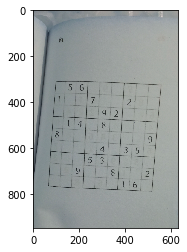

2 5 6 | 8 1 4 | 9 7 3 
1 9 8 | 7 5 3 | 2 4 6 
4 7 3 | 6 9 2 | 5 8 1 
------+-------+------
9 1 4 | 3 8 5 | 6 2 7 
8 3 5 | 2 7 6 | 4 1 9 
7 6 2 | 9 4 1 | 3 5 8 
------+-------+------
6 2 1 | 5 3 7 | 8 9 4 
5 4 9 | 1 6 8 | 7 3 2 
3 8 7 | 4 2 9 | 1 6 5 



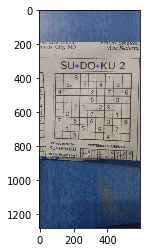

2 7 8 | 6 9 5 | 1 4 3 
5 3 6 | 7 1 4 | 8 9 2 
4 9 1 | 8 2 3 | 7 5 6 
------+-------+------
6 1 4 | 9 5 8 | 2 3 7 
8 5 7 | 1 3 2 | 9 6 4 
9 2 3 | 4 7 6 | 5 1 8 
------+-------+------
7 4 5 | 2 6 1 | 3 8 9 
3 8 2 | 5 4 9 | 6 7 1 
1 6 9 | 3 8 7 | 4 2 5 



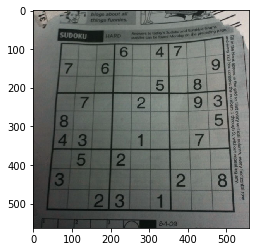

5 8 3 | 6 9 4 | 7 2 1 
7 1 6 | 8 3 2 | 5 4 9 
2 9 4 | 1 7 5 | 3 8 6 
------+-------+------
6 7 1 | 5 2 8 | 4 9 3 
8 2 9 | 7 4 3 | 1 6 5 
4 3 5 | 9 1 6 | 8 7 2 
------+-------+------
1 5 8 | 2 6 7 | 9 3 4 
3 6 7 | 4 5 9 | 2 1 8 
9 4 2 | 3 8 1 | 6 5 7 



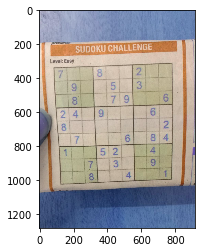

7 3 4 | 8 6 1 | 2 5 9 
6 9 1 | 4 5 2 | 3 7 8 
5 8 2 | 3 7 9 | 4 1 6 
------+-------+------
2 4 5 | 9 8 3 | 1 6 7 
8 1 6 | 7 4 5 | 9 3 2 
9 7 3 | 2 1 6 | 5 8 4 
------+-------+------
1 6 9 | 5 2 7 | 8 4 3 
4 2 7 | 1 3 8 | 6 9 5 
3 5 8 | 6 9 4 | 7 2 1 



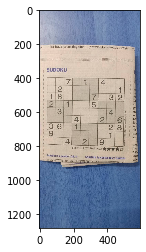

6 5 7 | 3 1 2 | 4 8 9 
4 2 3 | 9 6 8 | 5 7 1 
1 8 9 | 5 4 7 | 6 3 2 
------+-------+------
2 4 1 | 6 7 5 | 8 9 3 
5 3 6 | 2 8 9 | 1 4 7 
7 9 8 | 4 3 1 | 2 5 6 
------+-------+------
3 6 5 | 1 9 4 | 7 2 8 
9 7 2 | 8 5 6 | 3 1 4 
8 1 4 | 7 2 3 | 9 6 5 



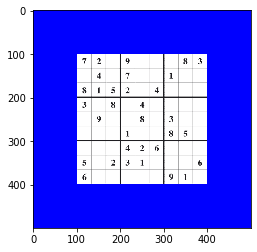

7 2 6 | 9 5 1 | 4 8 3 
9 4 3 | 7 6 8 | 1 2 5 
8 1 5 | 2 3 4 | 6 7 9 
------+-------+------
3 5 8 | 6 4 7 | 2 9 1 
4 9 1 | 5 8 2 | 3 6 7 
2 6 7 | 1 9 3 | 8 5 4 
------+-------+------
1 7 9 | 4 2 6 | 5 3 8 
5 8 2 | 3 1 9 | 7 4 6 
6 3 4 | 8 7 5 | 9 1 2 



In [9]:
# fancy check to ensure that this segment runs only if we ran this from this file itself
# and not for including it somewhere else

def solve_visudoku(img_path, debug=False):
    # get the image
    img = get_sudoku_image(img_path)
    
    if debug:
        plt.imshow(img)
        plt.show()

    # make a copy of the original image [used later]
    copy = img

    # pre-process image
    img = pre_process(img)
    
    if debug:
        plt.imshow(img, cmap='gray')
        plt.show()

    # extract corners of the puzzle
    corners = get_corners(img)
    # draw boundary on the image
    marked = mark_boundary(copy, corners)

    if debug:
        plt.imshow(marked)
        plt.show()
    
    puzzle = extract_rect(img, corners)
    
    if debug:
        plt.imshow(puzzle)
        plt.show()
    
    digits, boxed_digits = get_digits(puzzle)
    
    if debug:
        plt.imshow(boxed_digits)
        plt.show()
    
    model = get_model()
    nums = []
    
    for dig in digits:
        num = classify_img(model, dig['img'])
        
        if debug:
            print(num)
            plt.imshow(dig['img'], cmap='gray')
            plt.show()
        
        nums.append(classify_img(model, dig['img']))
        
    print(solve(' '.join(nums)))

    
if is_running():
    for i in range(6):
        img_path = f"test-images/test{i}.jpg"
        
        img = cv.imread(img_path)
        plt.imshow(img)
        plt.show()
        
        solve_visudoku(f"test-images/test{i}.jpg")